<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/relativeHighUtilityPattern/basic/RHUIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Relative High Utility Patterns in Utility Databases using RHUIM

This tutorial has two parts. In the first part, we describe the basic approach to find Relative High Utility Patterns in a Utility database using the RHUIM algorithm. In the final part, we describe an advanced approach, where we evaluate the RHUIM algorithm on a dataset at different minimum utility threshold values.
***

# Prerequisites:



1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=990fa18cc2da7e7cd144eadd6dd3e2375b2bfaac7c6a3f3b5e6943c97b9ac557
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=80daa29323ff25c6fadbf54a29c3050d10d9b35591fc7eb375e423300e1e8331
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/utilityDatabases/Utility_T10I4D100K.csv #download a sample utility database

--2023-09-05 13:13:49--  https://u-aizu.ac.jp/~udayrage/datasets/utilityDatabases/Utility_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7356594 (7.0M) [text/csv]
Saving to: ‘Utility_T10I4D100K.csv’

Utility_T10I4D100K. 100%[===================>]   7.02M  1.96MB/s    in 4.2s    

2023-09-05 13:13:55 (1.69 MB/s) - ‘Utility_T10I4D100K.csv’ saved [7356594/7356594]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Utility_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834:852:25	96	32	50	20	80	48	58	75	86	64	57	16	14	46	85 
39	120	124	205	401	581	704	814	825	834:396:6	60	42	58	31	53	10	52	22	62 


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Relative High Utility Patterns using RHUIM

### Step 1: Understanding the statistics of a database to choose an appropriate minimum Support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.UtilityDatabase as stats

#specify the file name
inputFile = 'Utility_T10I4D100K.csv'

#initialize the class
obj=stats.UtilityDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

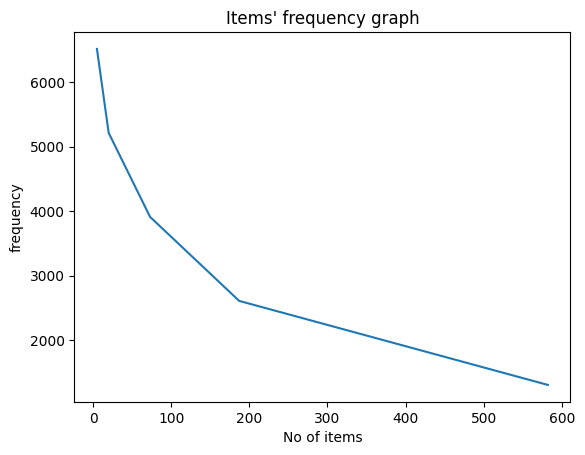

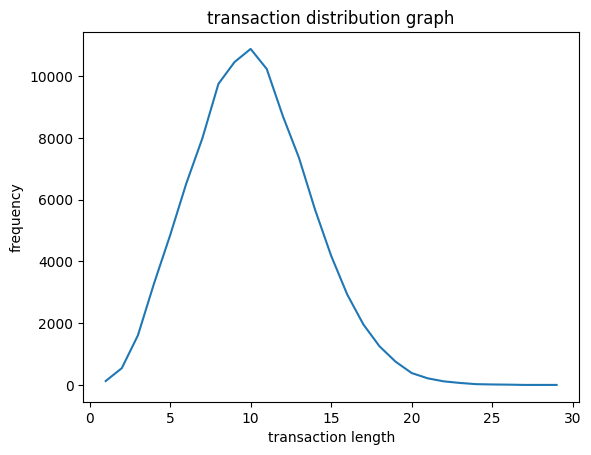

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 100 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
minUtilCount=50000  #minUtilCount is specified in count. However, the users can also specify minUtilCount between 0 and 1.
minUtilRatio=0.6 #minUtilRatio is specified in count. However, the users can also specify different value.

### Step 4: Mining Relative High Utility Patterns using RHUIM

In [9]:
from PAMI.relativeHighUtilityPattern.basic import RHUIM as alg #import the algorithm

obj = alg.RHUIM(iFile=inputFile, minUtil=minUtilCount, minUR=minUtilRatio, sep='\t') #initialize
obj.startMine()            #start the mining process

obj.save('relativeHighUtilityPatternsAtMinUtilCount50000.txt') #save the patterns

frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Relative High Utility patterns were generated successfully using RHUIM algorithm
Total No of patterns: 5968
Runtime: 156.6926863193512
Memory (RSS): 247193600
Memory (USS): 199917568


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minUtil_ value.

In [11]:
!head 'relativeHighUtilityPatternsAtMinUtilCount50000.txt'

644	926	922	94	198	129:50155:0.164006526907142 
644	926	922	94	198	129	78:56458:0.13088675089834242 
644	926	922	94	198	78:50030:0.1413093213876163 
644	926	922	198	129	78:51475:0.13872905588779857 
267	209	329	440	411	296:55204:0.14136820162971386 
267	209	329	440	411	296	803:60167:0.11924930829177799 
267	209	329	440	411	296	803	722:66494:0.08327322092312625 
267	209	329	440	411	296	722:61745:0.09021059121577199 
267	209	329	440	411	803:53967:0.1364567319362408 
267	209	329	440	411	803	722:59683:0.08656685677154345 


The storage format is: _relativeHighUtilityPattern:support_
***

## Part 2: Evaluating the RHUIM algorithm on a dataset at different minUtilCount values

### Step 1: Import the libraries and specify the input parameters

In [12]:
#Import the libraries
from PAMI.relativeHighUtilityPattern.basic import RHUIM as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Utility_T10I4D100K.csv'
seperator='\t'
minUtilRatio=0.6
minimumSupportCountList = [10000, 20000, 30000, 40000, 50000]
#minimumSupportCountList can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of RHUIM

In [13]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'minUR', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of RHUIM algorithm

### Step 3: Execute the algorithm at different minUtil values

In [14]:
for minSup in minimumSupportCountList:
    obj = alg.RHUIM(inputFile, minUtil=minSup, minUR=minUtilRatio, sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['RHUIM', minSup, minUtilRatio, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Relative High Utility patterns were generated successfully using RHUIM algorithm
Relative High Utility patterns were generated successfully using RHUIM algorithm
Relative High Utility patterns were generated successfully using RHUIM algorithm
Relative High Utility patterns were generated successfully using RHUIM algorithm
Relative High Utility patterns were generated successfully using RHUIM algorithm


### Step 4: Print the Result

In [15]:
print(result)

  algorithm  minSup  minUR  patterns     runtime     memory
0     RHUIM   10000    0.6     42179  214.023971  257654784
1     RHUIM   20000    0.6     23299  200.201108  249917440
2     RHUIM   30000    0.6     14468  188.338516  246059008
3     RHUIM   40000    0.6      9408  180.063571  245026816
4     RHUIM   50000    0.6      5968  159.750603  245026816


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

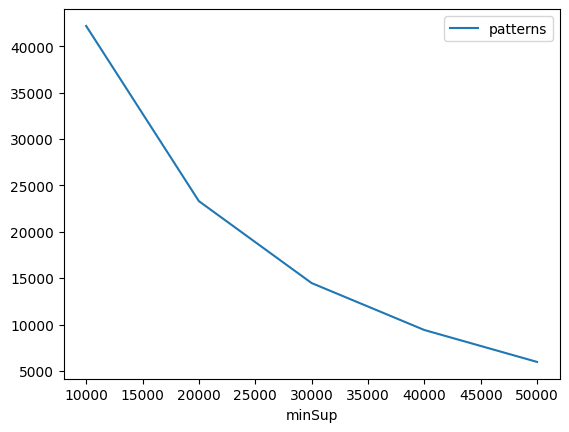

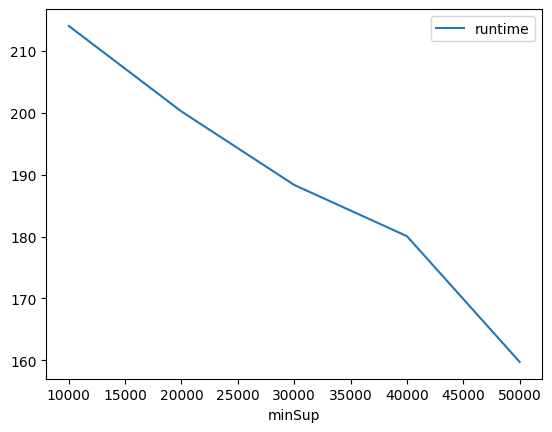

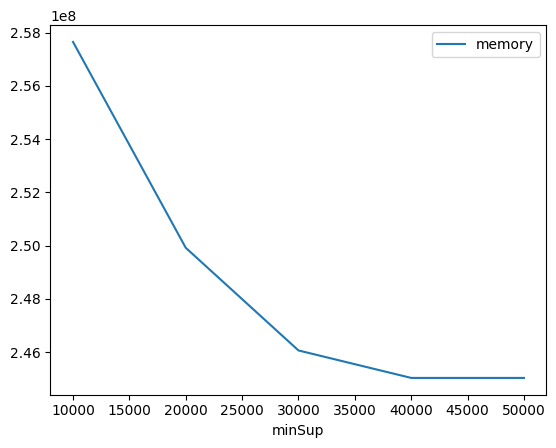

In [16]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib